In [2]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document


from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json
from dataclasses import dataclass, asdict

/home/arminas_work/projects/AI-Engineering_Bootcamp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Output models


In [14]:
@dataclass
class RetrievalOutput:
    retrieved_context_id: str
    retrieved_context: str
    retrieved_context_rating: float
    similarity_score: float

In [15]:
qdrant_client = QdrantClient(url="http://localhost:6333")

In [16]:
def get_embedding(text:str, model:str ="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding

In [17]:
def retrieve_data(
        query:str, 
        qdrant_client: QdrantClient, 
        k:int=5
    )-> list[RetrievalOutput]:

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieval_outputs = []

    for result in results.points:
        retrieval_output= RetrievalOutput(
            retrieved_context_id= result.payload["parent_asin"],
            retrieved_context= result.payload["description"],
            retrieved_context_rating = result.payload["average_rating"],
            similarity_score = result.score
        )
        retrieval_outputs.append(retrieval_output)



    return retrieval_outputs

In [18]:
query = "Can I get a tablet?"

In [19]:
answer = retrieve_data(query, qdrant_client, k=10)

Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 27.74it/s]


In [20]:
answer

[RetrievalOutput(retrieved_context_id='B0B8NVNQKX', retrieved_context='COOPERS 7 inch Kids Tablet Android 11 Tablet for Kids, 2GB RAM + 32GB ROM Toddler Tablet PC for Children, IPS Touch Screen, Dual Camera, Dual Speaker, WiFi Computer Tablet, Light Blue✿【Good Kids tablet】This 7 inch tablet for kids with silm body and lightweight, it is easy to hold by children. Also the special design can protect the tablet well when dropping. ✿【Parental Control】Toddlers Tablet with parent mode can add or block apps. Set screen time limits. This tablet come with iwawa app. kids can get access to fun and educational games and videos. ✿【Powerful Tablets】Equipmented with quad core CPU, Android 11.0 System, 32GB Big Storage, 1024*600 IPS Screen offer a clear view. Runs Kinds of apps and game for kids smoothly. ✿【Long Lasting】Tablet for kids built with large capacity battery. For mixed use up to 6 hours. You can enjoy happy parent-child time with your kids. ✿【Best Gift】This high performance Children tablet

##Multi-intent Questions

In [21]:
query = "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"

In [22]:
class QueryExpandResponse(BaseModel):
   statements: List[str]

In [23]:
def query_expand_node(query) -> dict:

    prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

    Instructions:
    - You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
    - The statements should not overlap in context.

    <Question>
    {{ query }}
    </Question>
    """

    template = Template(prompt_template)
    
    prompt = template.render(
        query=query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
            model="gpt-4.1-mini",
            response_model=QueryExpandResponse,
            messages=[{"role": "system", "content": prompt}],
            temperature=0.5,
    )
    return response


In [24]:
answer = query_expand_node(query)

In [25]:
answer

QueryExpandResponse(statements=['tablet suitable for kids', 'watch for adults', 'laptop for wife'])

# LangGraph

### Query Expansion (Sequential)

In [21]:
class RetrievalOutput(BaseModel):
    context_id: str
    context: str
    rating: float
    similarity_score: float


class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[RetrievalOutput], add] = []
    initial_query: str = ""
    answer: str = ""

### Query expansion and RW node

In [5]:
class QueryExpandResponse(BaseModel):
   expanded_query: List[str]

In [19]:
@traceable(
    name="query_expand_node",
    run_type="llm",
    metadata={"ls_provider":"openai", "ls_model_name":"gpt-4.1-mini"}

)

def query_expand_node(state: State) -> dict:

    prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

    <Exmaple>
    Question: Can you suggest me earphones, and parfumes for my girlfirend?

    Returned statements:
    -Earphones
    -Women parfume

    </Example>

    Instructions:
    - You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
    - The statements should not overlap in context.

    <Question>
    {{ query }}
    </Question>
    """

    template = Template(prompt_template)
    
    prompt = template.render(
        query=state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
            model="gpt-4.1-mini",
            response_model=QueryExpandResponse,
            messages=[{"role": "system", "content": prompt}],
            temperature=0,
    )

    return {
        "expanded_query": response.expanded_query
    }

### Retriever node

In [ ]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text:str, model:str ="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve_data(
        query:str,
        k:int=5
    )-> list[RetrievalOutput]:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieval_outputs = []

    for result in results.points:
        retrieval_output= RetrievalOutput(
            context_id= result.payload["parent_asin"],
            context= result.payload["description"],
            rating = result.payload["average_rating"],
            similarity_score = result.score
        )
        retrieval_outputs.append(retrieval_output)

    return retrieval_outputs

@traceable(
    name="retriever_node",
    run_type="retriever"
)
def retriever_node(state:State) -> dict:

    retrieved_context = []

    for query in state.expanded_query:
        retrieved_data = retrieve_data(query, k=5)
        for obj in retrieved_data:
            retrieved_context.append(obj)

    return{
        "retrieved_context": retrieved_context
    }

### Aggregator

In [9]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")


In [22]:
@traceable(
    name="aggregator_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = json.dumps([obj.model_dump(exclude={'similarity_score'}) for obj in state.retrieved_context])

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

In [11]:


workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retriever_node", retriever_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_edge("query_expand_node", "retriever_node")
workflow.add_edge("retriever_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()



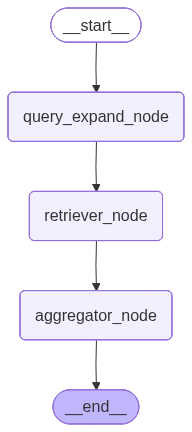

In [12]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
query = "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
initial_state = {
    "initial_query": query,
}

In [14]:
result = graph.invoke(initial_state)

Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 28.72it/s]


In [23]:
result

{'expanded_query': ['tablet suitable for kids',
  'smartwatch for adults',
  'laptop for women'],
 'retrieved_context': [RetrievalOutput(retrieved_context_id='B0C3XYD574', retrieved_context='ROWT Tablet for Kids 10 inch Kids Tablet 2GB RAM 32GB ROM Android 11 6000mAh Wi-Fi, Bluetooth, Kid-Proof Case(Blue)【Kids\' Safety & Parental Controls】Looking for a safe tablet that\'s easy for your kids to use? This 10-inch tablet for kids is GMS-certified, has password protection, a content filter, and a one-button lock screen, making it easier for parents to keep an eye on their kids activities and learning. 【Creative Educational Content】Our kids tablet provides access to a range of age-appropriate creative kids content such as drawing, educational games, eBooks, learning videos, math tools, and much more! Learning through play is best for kids to understand the world. 【Powerful Configuration & Full Access to Google】This Android 11 kids tablet has an HD 1280x800 IPS touchscreen, 1.6 GHz Quad-Core

In [15]:
print(result["answer"])

Tablet for your kid:
- ROWT Tablet for Kids 10 inch
  - 2GB RAM, 32GB ROM
  - Android 11
  - 6000mAh battery
  - Wi-Fi, Bluetooth
  - Kid-proof case (Blue)
  - GMS-certified with parental controls like password protection, content filter, one-button lock screen
  - HD 1280x800 IPS touchscreen
  - 1.6 GHz Quad-Core processor
  - Dual cameras
  - Eye protection with reduced blue light
  - Durable protective case with built-in stand

Watch for you:
- Smart Watch, Touch Screen Fitness Tracker
  - 1.69" full touch color screen, 240x280 resolution
  - 100+ watch faces, customizable wallpaper
  - 25 sports modes including walking, running, cycling, etc.
  - 24/7 heart rate and sleep monitor
  - Multifunction including pedometer, calories, stopwatch, timer, blood oxygen monitor, notifications for calls, SMS, apps
  - IP68 waterproof
  - Compatible with iOS 9.0/Android 4.0 or above
  - 1.5 hours charge, up to 7 days usage

Laptop for your wife:
- Focdod Laptop Backpack Women Work Bookbag
  - Fi

### Parallel Query Expansion

In [25]:
class RetrievalOutput(BaseModel):
    context_id: str
    context: str
    rating: float
    similarity_score: float


class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[RetrievalOutput], add] = []
    initial_query: str = ""
    answer: str = ""
    query:str = ""
    k:int = 5 

#### Query expansion

In [ ]:
class QueryExpandResponse(BaseModel):
   expanded_query: List[str]

@traceable(
    name="query_expand_node",
    run_type="llm",
    metadata={"ls_provider":"openai", "ls_model_name":"gpt-4.1-mini"}
)
def query_expand_node(state: State) -> dict:

    prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

    <Exmaple>
    Question: Can you suggest me earphones, and parfumes for my girlfirend?

    Returned statements:
    -Earphones
    -Women parfume

    </Example>

    Instructions:
    - You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
    - The statements should not overlap in context.

    <Question>
    {{ query }}
    </Question>
    """

    template = Template(prompt_template)
    
    prompt = template.render(
        query=state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
            model="gpt-4.1-mini",
            response_model=QueryExpandResponse,
            messages=[{"role": "system", "content": prompt}],
            temperature=0,
    )

    return {
        "expanded_query": response.expanded_query
    }

In [28]:
def query_expand_conditional_edges(state: State):

    send_messages = []

    for query in state.expanded_query:
        send_messages.append(
            Send(
                "retriever_node",
                {
                    "query": query,
                    "k": 10
                }
            )
        )

    return send_messages

#### Retriever node

In [ ]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text:str, model:str ="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retriever_node(state: State)-> list[RetrievalOutput]:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state['query'])
    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=state['query'],
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieval_outputs = []

    for result in results.points:
        retrieval_output= RetrievalOutput(
            context_id= result.payload["parent_asin"],
            context= result.payload["description"],
            rating = result.payload["average_rating"],
            similarity_score = result.score
        )
        retrieval_outputs.append(retrieval_output)

    return {
        "retrieved_context": retrieval_outputs
    }

#### Aggregator

In [38]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

@traceable(
    name="aggregator_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = json.dumps([obj.model_dump(exclude={'similarity_score'}) for obj in state.retrieved_context])

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

#### Graph

In [33]:

workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retriever_node", retriever_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_conditional_edges(
    "query_expand_node", query_expand_conditional_edges
)
workflow.add_edge("retriever_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

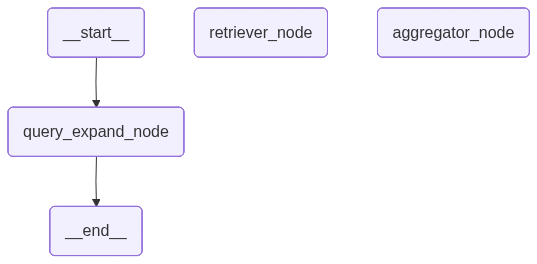

In [34]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
query = "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
initial_state = {
    "initial_query": query,
}

result = graph.invoke(initial_state)

In [36]:
result

{'expanded_query': ['tablet for kids', 'watch for men', 'laptop for women'],
 'retrieved_context': [RetrievalOutput(context_id='B0BL2CZSHT', context='All-New 10and 10 Plus 2021 Tablet Case for Kids, Ubearkk Adult & Kids Friendly Light Weight Shock Proof Kid-Proof Back Cover Compatible 101h Generation 2021 ModelCompatibility- Designed for All-New ＨＤ 10 & ＨＤ 10 Plus Tablet & ＨＤ 10 Kids Pro Tablet Latest model(Only compatible with 11th Generation, 2021 Release). NOT Fit for other generations. Kids-proof Case-Made with dense heavy duty EVA foam material can withstand considerable wear and tear and provide extreme shock protection. Super light weight and durable hazard free safe material perfect for kids and grownups alike. Built-in Kickstand - Designed with a foldable kick-stand on the back of the case, allows you to set up multiple angles and gives you the hands-free convenience when watching videos and movies. Precise cutouts- Full access to all ports, buttons, and cameras, speakers and 

In [37]:
print(result['answer'])

Yes, you can get a tablet for your kid, a watch for yourself, and a laptop for your wife from the available products. Here are some options:

Tablet for Kids:
- ROWT Tablet for Kids 10 inch
  - Android 11 OS
  - 2GB RAM, 32GB ROM
  - 6000mAh battery
  - HD 1280x800 IPS touchscreen
  - Kid-proof case with built-in stand
  - Parental controls and safety features

Watch for Men:
- Military Smart Watch for Men
  - IP68 waterproof, dustproof, shockproof
  - Heart rate, blood oxygen, sleep monitoring
  - Multiple sports modes
  - Make/receive calls with built-in speaker and mic
  - Up to 30 days battery life standby

Laptop for Wife:
- Lenovo Newest Ideapad 15.6" Laptop
  - AMD Athlon Silver 3050U processor
  - 4GB DDR4 RAM, 128GB PCIe SSD
  - 15.6 inch HD IPS display
  - WiFi 6 and Bluetooth 5.0
  - Windows 11 Home in S Mode
  - Lightweight and portable

These products cover your needs for a kid's tablet, a smartwatch for men, and a laptop suitable for your wife.
